# Minimal MNIST Demo for Classification

Showcase the power of an associative memory on MNIST

Load important libraries. Modify GPU usage details here.

In [ ]:
%reload_ext autoreload 
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"

In [ ]:
import jax
import jax.numpy as jnp
import hamux as hmx
import treex as tx
from flax import linen as nn # For initializers
import optax
import jax.tree_util as jtu
from typing import *
import matplotlib.pyplot as plt
from dataclasses import dataclass
from loguru import logger
from einops import rearrange
from tqdm.auto import trange, tqdm
from pathlib import Path
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.colors as colors
plt.set_cmap('bwr') # a good start: blue to white to red colormap

<Figure size 800x800 with 0 Axes>

In [ ]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

# Training functions

For the classification task.

In [ ]:
class TrainState(tx.Module):
    model: tx.Module
    optimizer: tx.Optimizer
    apply_fn: Callable
    filter_betas: bool
    rng: jnp.ndarray = tx.Rng.node()
    eval_rng: jnp.ndarray = tx.Rng.node()

    def __init__(
        self, model, optimizer, apply_fn, rng, filter_betas=False, do_normal_init=False
    ):
        self.filter_betas = filter_betas
        self.model = model
        self.optimizer = tx.Optimizer(optimizer).init(self.params)
        self.apply_fn = apply_fn
        self.rng, self.eval_rng = jax.random.split(rng)
        self.do_normal_init = do_normal_init

    @property
    def params(self):
        if self.filter_betas:
            def good_name(x):
                A = "beta" not in x.name
                B = "delta" not in x.name
                C = "gamma" not in x.name
                return A and B and C
            return self.model.filter(good_name)
        return self.model.filter(tx.Parameter)

    def apply_updates(self, grads):
        new_params = self.optimizer.update(grads, self.params)
        self.model = self.model.merge(new_params)
        return self


def cross_entropy_loss(*, probs, labels):
    n_classes = probs.shape[-1]
    labels_onehot = jax.nn.one_hot(labels, num_classes=n_classes)
    # smoothed_labels = (0.1 / n_classes + labels_onehot)
    # smoothed_labels = smoothed_labels / jnp.abs(smoothed_labels).sum(-1, keepdims=True)
    smoothed_labels = labels_onehot
    
    stable_probs = (probs + 1e-6) / (1+(1e-6)*n_classes)
    loss = -jnp.sum(smoothed_labels * jnp.log(stable_probs), axis=-1).mean()
    loss = -jnp.sum(smoothed_labels * jnp.log(stable_probs), axis=-1).mean()

    return loss


def compute_metrics(*, probs, labels):
    loss = cross_entropy_loss(probs=probs, labels=labels)
    accuracy = jnp.mean(jnp.argmax(probs, -1) == labels)
    metrics = {
      "probs_min": probs.min(),
      'probs_max': probs.max(),
      'loss': loss,
      'accuracy': accuracy,
    }
    return metrics


@jax.jit
def train_step(state, batch):
    if state.do_normal_init:
        rng, state.rng = jax.random.split(state.rng)
    else:
        rng = None

    def loss_fn(params):
        state.model = state.model.merge(params)
        x = batch["image"]
        
        probs = state.apply_fn(state.model, x, rng=rng)
        loss = cross_entropy_loss(probs=probs, labels=batch["label"])
        return loss, (probs, state)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, (probs, state)), grads = grad_fn(state.params)

    state = state.apply_updates(grads)
    metrics = compute_metrics(probs=probs, labels=batch["label"])
    return state, metrics

@jax.jit
def eval_step(state, batch):
    x = batch["image"]
    if state.do_normal_init:
        rng = state.eval_rng
    else:
        rng = None
    probs = state.apply_fn(state.model, x, rng=rng)
    return compute_metrics(probs=probs, labels=batch['label'])

def train_epoch(state, train_dl, epoch):
    """Train for a single epoch."""
    batch_metrics = []
    bs = train_dl.batch_size
    for i, batch in enumerate(tqdm(train_dl, leave=False)):
        batch = {"image": jnp.array(batch[0]), "label": jnp.array(batch[1])}
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }
    return state, epoch_metrics_np["loss"], epoch_metrics_np["accuracy"]


def eval_model(state, test_dl):
    batch_metrics = []

    for i, batch in enumerate(test_dl):
        batch = {"image": jnp.array(batch[0]), "label": jnp.array(batch[1])}

        metrics = eval_step(state, batch)
        batch_metrics.append(metrics)
    batch_metrics_np = jax.device_get(batch_metrics)
    summary = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    return summary["loss"], summary["accuracy"]

# Model Evaluation Functions

In [ ]:
from hamux.datasets import *

dl_args = DataloadingArgs(
    dataset="torch/MNIST",
    # aa="rand",
    aa=None,
    reprob=0.,
    vflip=0.0,
    hflip=0.0,
    scale=(0.9, 1.1),
    batch_size=100,
    color_jitter=0.0,
    validation_batch_size=1000,
)
data_config = DataConfigMNIST(input_size=(1, 28, 28), mean=0.5, std=0.5)

train_dl, eval_dl = create_dataloaders(dl_args, data_config)

for batch in train_dl:
    imgs, labels = batch
    break
    
# plt.imshow(data_config.show(imgs[2]))

<matplotlib.colorbar.Colorbar>

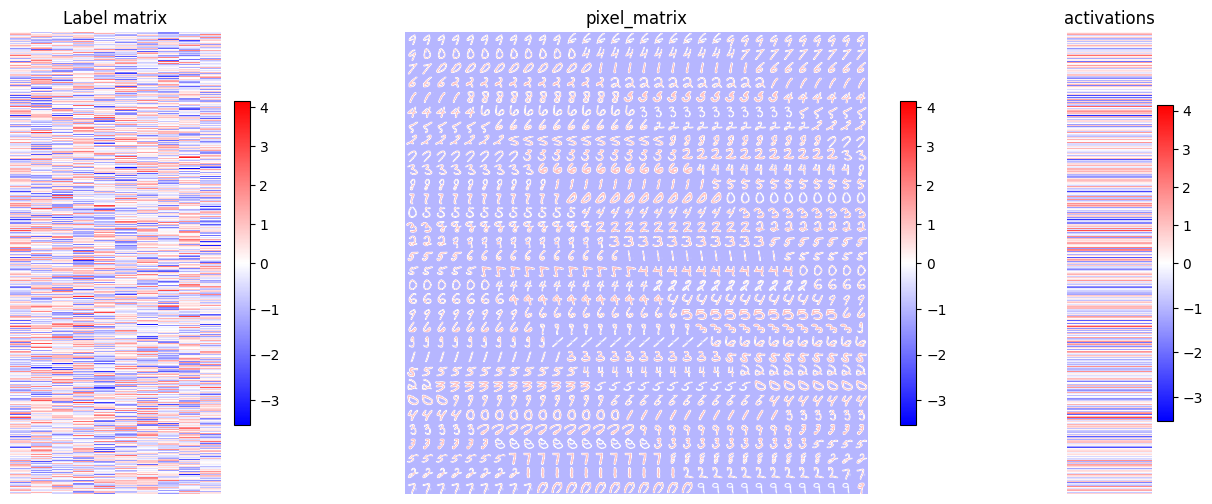

In [ ]:
norm = colors.TwoSlopeNorm(vcenter=0)

imgs_big = rearrange(np.repeat(imgs, 11, axis=0)[:1024], "... h w -> ... (h w)")[:,0].T
imgs_big_show = rearrange(imgs_big, "(h w) (kh kw) -> (kh h) (kw w)", h=28, w=28, kh=32, kw=32)

W2 = np.random.normal(size=(10,1024))
fig, axs = plt.subplots(1, 3, figsize=(15,6), width_ratios=(2,5,0.8))
def prep_axis(ax):
    ax.axis('off')
[prep_axis(ax) for ax in axs]

pos0 = axs[0].imshow(W2.T, aspect="auto", interpolation="nearest", norm=norm)
fig.colorbar(pos0, ax=axs[0], location="right", shrink=0.7)
axs[0].set_title("Label matrix")

pos1 = axs[1].imshow(imgs_big_show, norm=norm)
axs[1].set_title("pixel_matrix")
fig.colorbar(pos1, ax=axs[1], location="right", shrink=0.7)


axs[2].set_title("activations")
pos2 = axs[2].imshow(W2[:1].T, aspect="auto", interpolation="nearest", norm=norm)
fig.colorbar(pos2, ax=axs[2], location="right")

In [ ]:
def summarize_mnist_weights(ham, kh=32, kw=32, fig=None):
    # W2 = np.random.normal(size=(10,1024))
    norm = colors.TwoSlopeNorm(vcenter=0)

    Wimg = ham.synapses[0].W1
    Wlabel = ham.synapses[0].W2
    
    nWimg = jnp.sqrt(jnp.power(Wimg,2).sum(-2, keepdims=True))
    nWlabel = jnp.sqrt(jnp.power(Wlabel,2).sum(-2, keepdims=True))
    
    Wimg = Wimg / nWimg
    Wlabel = Wlabel / nWlabel
    
    # imgs_big = rearrange(np.repeat(imgs, 11, axis=0)[:1024], "... h w -> ... (h w)")[:,0].T
    Wimg_show = rearrange(Wimg, "(h w) (kh kw) -> (kh h) (kw w)", h=28, w=28, kh=kh, kw=kw)
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, figsize=(12,6), width_ratios=(2,5))
    else:
        axs = fig.subplots(1, 2, width_ratios=(2,5))
    def prep_axis(ax):
        ax.axis('off')
    [prep_axis(ax) for ax in axs]

    pos0 = axs[0].imshow(Wlabel.T[:20], aspect="auto", interpolation="nearest")
    # fig.colorbar(pos0, ax=axs[0], location="right", shrink=0.7)
    axs[0].set_title("Label matrix")

    pos1 = axs[1].imshow(Wimg_show, norm=norm)
    axs[1].set_title("pixel_matrix")
    fig.colorbar(pos1, ax=axs[1], location="right", shrink=0.7)


#     axs[2].set_title("activations")
#     pos2 = axs[2].imshow(W2[:1].T, aspect="auto", interpolation="nearest")
#     fig.colorbar(pos2, ax=axs[2], location="right")
    return fig

# Model Creation from Scratch

We rewrite the synapse and layer for a simple 2 layer CIFAR network

In [ ]:
def normal_init(std=1.0, mean=0.0):
    def _f(key, shape, dtype=jnp.float64):
        return (jax.random.normal(key, shape, dtype=dtype) * std) + mean
    return _f

In [ ]:
class HopfieldNetworkAsSynapse(hmx.Synapse):
    """A simple reimplementation of a Hopfield Network as a synapse, returning the alignment"""
    W1: jnp.ndarray = tx.Parameter.node() # treex's preferred way of declaring an attribute as a parameter
    W2: jnp.ndarray = tx.Parameter.node()
    nhid: int
    beta: float = tx.Parameter.node()
    
    def __init__(self, nhid:int, beta_init=0.1):
        self.nhid = nhid
        self.beta = beta_init
    
    def __call__(self, g1, g2):
        """The alignment function, defined on an unbatched `g`"""
        if self.initializing():
            self.W1 = normal_init(mean=0.0, std=0.01)(tx.next_key(), g1.shape + (self.nhid,))
            self.W2 = normal_init(std=0.01)(tx.next_key(), g2.shape + (self.nhid,))
        # hidsig = g1 @ self.W1 + g2 @ self.W2
        # hidsig = - jnp.abs(self.W1 - g1[:,None]).sum(-2) - jnp.abs(self.W2 - g2[:,None]).sum(-2)
        # hidsig = - jnp.pow(jnp.abs(self.W1 - g1[:,None]),2).sum(-2) - jnp.pow(jnp.abs(self.W2 - g2[:,None]),2).sum(-2)

        # nW1 = jnp.abs(self.W1).sum(-2, keepdims=True)
        # nW2 = jnp.abs(self.W2).sum(-2, keepdims=True)
        nW1 = jnp.sqrt(jnp.power(self.W1,2).sum(-2, keepdims=True))
        nW2 = jnp.sqrt(jnp.power(self.W2,2).sum(-2, keepdims=True))
        
        hidsig = g1 @ (self.W1 / nW1) + g2 @ (self.W2 / nW2)

        # hid_lagrangian_value = 1/self.beta * jax.nn.logsumexp(self.beta * hidsig, axis=-1)
        hid_lagrangian_value = (1/self.beta * jnp.exp(self.beta * hidsig)).sum(-1)
        return hid_lagrangian_value
    
ImageLayer = hmx.Layer(hmx.lagrangians.LSphericalNorm(), (28*28,))
# ImageLayer = hmx.Layer(hmx.lagrangians.LTanh(beta=0.5), (28*28,))
LabelLayer = hmx.Layer(hmx.lagrangians.LSoftmax(beta=0.005), (10,))

layers = [ImageLayer, LabelLayer]
synapses = [HopfieldNetworkAsSynapse(nhid=32**2, beta_init=7.)]
connections = [((0,1),0)]
ham = hmx.HAM(layers, synapses, connections)

A layer is uniquely defined by a lagrangian function and a neuron shape

In [ ]:
def fwd(model, x, depth=1, dt=0.5, rng=None):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(x.shape[0], rng=rng)
    xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # NORMALIZE IMAGES
    nx = jnp.sqrt(jnp.power(xs[0], 2).sum(-1, keepdims=True))
    xs[0] = xs[0] / nx

    # Masks allow us to clamp our visible data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)
    masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return model.layers[-1].g(xs[-1]) # Probs
    # return xs[-1] # Logits

In [ ]:
imgs_np = np.array(imgs)
nimg = jnp.sqrt(jnp.power(imgs_np, 2).sum(-1, keepdims=True))
normed_img = imgs_np / nimg

In [ ]:
jax_key = jax.random.PRNGKey(0)
k1, jax_key = jax.random.split(jax_key)
lr = 0.001
num_epochs = 100
states, ham = ham.init_states_and_params(k1, bs=1)

<matplotlib.image.AxesImage>

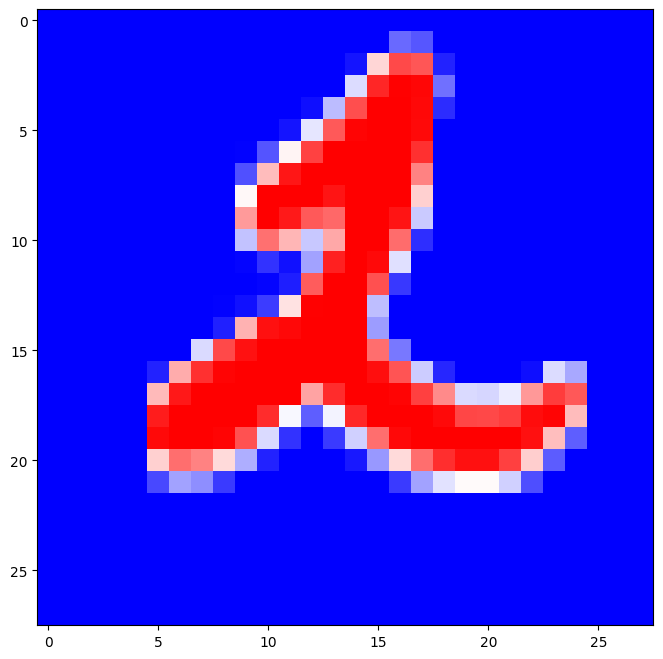

In [ ]:
from hamux.datasets import *

dl_args = DataloadingArgs(
    dataset="torch/MNIST",
    # aa="rand",
    aa=None,
    reprob=0.,
    vflip=0.0,
    hflip=0.0,
    scale=(0.9, 1.1),
    batch_size=100,
    color_jitter=0.0,
    validation_batch_size=1000,
)
data_config = DataConfigMNIST(input_size=(1, 28, 28), mean=0.5, std=0.5)

train_dl, eval_dl = create_dataloaders(dl_args, data_config)

for batch in train_dl:
    imgs, labels = batch
    break
    
plt.imshow(data_config.show(imgs[2]))

In [ ]:
# ham, forward_classification = hmx.create_model(args.model)

optimizer = optax.adamw(0.0001)
state = TrainState(
    ham,
    optimizer,
    fwd,
    rng=jax_key,
    filter_betas=True,
)


def get_nparams(model):
    params, meta = jtu.tree_flatten(model.parameters())

    def get_nel(x):
        try:
            return x.size
        except AttributeError:  # float
            return 1

    return sum([get_nel(p) for p in params])


def escape_ansi(line):
    import re

    ansi_escape = re.compile(r"(?:\x1B[@-_]|[\x80-\x9F])[0-?]*[ -/]*[@-~]")
    return ansi_escape.sub("", line)

logger.info(f"NParams={get_nparams(state.model)}")
logger.info(escape_ansi(state.model.tabulate()))

/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treex/optimizer.py:79: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  params = jax.tree_leaves(params)
2022-11-30 18:58:35.278 | INFO     | __main__:<module>:31 - NParams=813058
/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treex/module.py:241: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  flat, _ = jax.tree_flatten(self)
/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treex/utils.py:167: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  tree_types = jax.tree_flatten(
/nethome/bhoover30/miniconda3/envs/hamux/lib/python3.9/site-packages/treex/utils.py:375: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future re

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path                  ┃ module                 ┃ params                  ┃ Parameter      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ *                     │ HAM()                  │                         │                │
├───────────────────────┼────────────────────────┼─────────────────────────┼────────────────┤
│ .layers[0]            │ Layer()                │ bias: None              │                │
│                       │                        │                         │                │
├───────────────────────┼────────────────────────┼─────────────────────────┼────────────────┤
│ .layers[0].lagrangian │ LSphericalNorm()       │                         │                │
├───────────────────────┼────────────────────────┼─────────────────────────┼────────────────┤
│ .layers[1]            │ Layer()                │ bias: None              │                │
│                       │                        │                         │                │
├───────────────────────┼────────────────────────┼─────────────────────────┼────────────────┤
│ .layers[1].lagrangian │ LSoftmax()             │ beta: 0.005             │                │
│                       │                        │                         │                │
├───────────────────────┼────────────────────────┼─────────────────────────┼────────────────┤
│ .synapses[0]          │ HopfieldNetworkAsSyna… │ W1: Parameter(784,      │ 813,056  3.3MB │
│                       │                        │ 1024)  float32          │                │
│                       │                        │ W2: Parameter(10, 1024) │                │
│                       │                        │ float32                 │                │
│                       │                        │ beta: 7.0               │                │
├───────────────────────┼────────────────────────┼─────────────────────────┼────────────────┤
│                       │                        │                  Total: │ 813,056  3.3MB │
└───────────────────────┴────────────────────────┴─────────────────────────┴────────────────┘
                                                                                             
                              Total Parameters: 813,056  3.3MB                               

2022-11-30 18:58:35.292 | INFO     | __main__:<module>:32 - 


In [ ]:
%matplotlib inline
from IPython import display

# ===========================================
## Training
# ===========================================
@dataclass
class CkptTracker:
    base_name: str
    model: tx.Module = None
    epoch: int = -1
    best_acc: float = -1

    def get_save_name(self):
        return f"{self.base_name}_epoch-{self.epoch}_acc-{100*self.best_acc:.3f}.pckl"


train_acc_list = []
test_acc_list = []
ckpt_tracker = CkptTracker("DummyMNIST")
logdir = Path("./_logs")
logdir.mkdir(exist_ok=True, parents=True)

# fig, axs = plt.subplots(1, 2, figsize=(12,6), width_ratios=(2,5))
test_acc = 0
with trange(1, num_epochs + 1, unit="epochs") as pbar:
    for epoch in pbar:
        if (epoch-1) % 1 == 0:
            display.clear_output(wait=True)
            print(f"Epoch: {epoch}, acc = {100*test_acc:0.2f}")
            fig = summarize_mnist_weights(state.model)
            display.display(fig)

        state, train_loss, train_acc = train_epoch(state, train_dl, epoch)
        test_loss, test_acc = eval_model(state, eval_dl)
        if test_acc > ckpt_tracker.best_acc:
            old_ckpt_name = str(logdir / ckpt_tracker.get_save_name())
            try:
                os.remove(old_ckpt_name)
            except Exception as e:
                logger.debug(f"Couldn't remove {old_ckpt_name}, {e}")
                pass
            ckpt_tracker.model = state.model
            ckpt_tracker.epoch = epoch
            ckpt_tracker.best_acc = test_acc
            to_save = jtu.tree_map(hmx.utils.to_pickleable, ckpt_tracker.model.to_dict())
            ckpt_name = str(logdir / ckpt_tracker.get_save_name())
            hmx.utils.pytree_save(to_save, ckpt_name, overwrite=True)
        desc = f"[{epoch}/{num_epochs}] | BestAcc: {100*ckpt_tracker.best_acc:.3f} | TrainLoss: {train_loss:.2f} | TrainAcc: {100*train_acc:.2f}"
        addition = f"curr_val_acc={100*test_acc:0.2f}"
        logger.info(desc + " | " + addition)
        pbar.set_description(desc)
        pbar.set_postfix(
            train_acc=f"{100*train_acc:0.2f}", val_acc=f"{100*test_acc:0.2f}"
        )


# Analysis

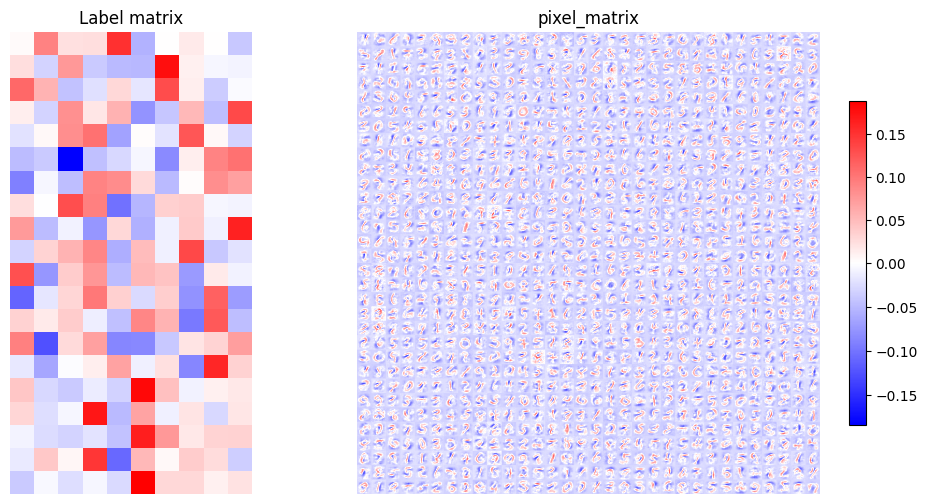

In [ ]:
model_fname = "_logs/DummyMNIST_epoch-67_acc-97.890.pckl"
loaded_model = hmx.HAM.load_ckpt(state.model, model_fname)
summarize_mnist_weights(loaded_model);

In [ ]:
a = jnp.zeros((2,3,45,))

In [ ]:
def fwd_energy(model, x, depth=4, dt=0.4, rng=None):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(x.shape[0], rng=rng)
    xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # Masks allow us to clamp our visible data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)
    
    # if clamp_label is not None:
    #     xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1.)
    #     print(xs[-1])
    #     masks[-1] = jnp.zeros_like(masks[-1])

    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
    all_xs = [xs]
    energies = [model.venergy(xs)]

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states
        all_xs.append(xs)
        energies.append(model.venergy(xs))

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return jnp.stack(energies), all_xs

In [ ]:
img_start = batch[0][:1]
# img_start = jnp.ones_like(jnp.array(img_start))
energies, allxs = fwd_energy(loaded_model, img_start, dt=0.01, depth=30)

[<matplotlib.lines.Line2D>]

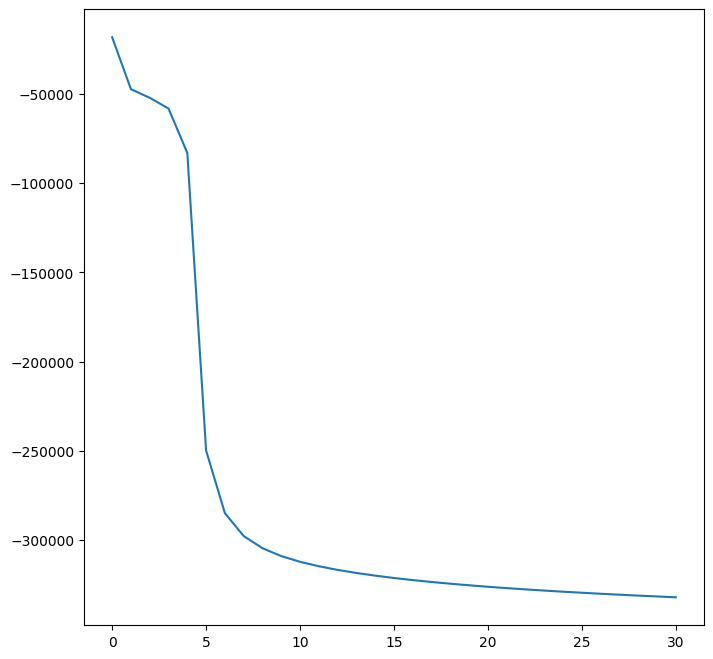

In [ ]:
plt.plot(energies)

<matplotlib.image.AxesImage>

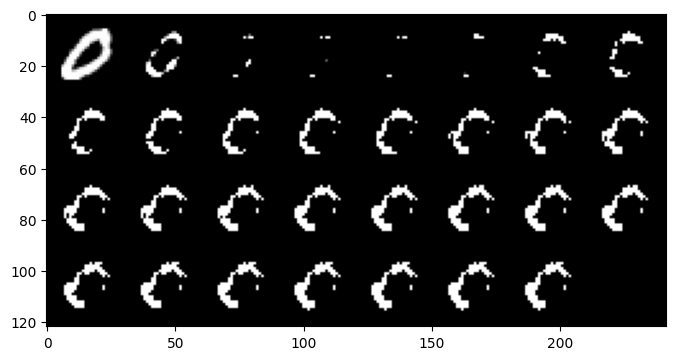

In [ ]:
from torchvision.utils import make_grid

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
    return data_config.show(torch.tensor(np.array(x)))

aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))

In [ ]:
def fwd_energy(model, clamp_label:int, depth=4, dt=0.4, rng=None):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(1, rng=rng)
    # xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # Masks allow us to clamp our label data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)

    xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1050.)
    # xs[-1] = xs[-1].at[...,1].set(1000.)
    print(xs[-1])
    masks[-1] = jnp.zeros_like(masks[-1])

    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
    all_xs = [xs]
    energies = [model.venergy(xs)]

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states
        all_xs.append(xs)
        energies.append(model.venergy(xs))

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return jnp.stack(energies), all_xs

Starting 0
Traced<ShapedArray(float32[1,10])>with<DynamicJaxprTrace(level=0/1)>


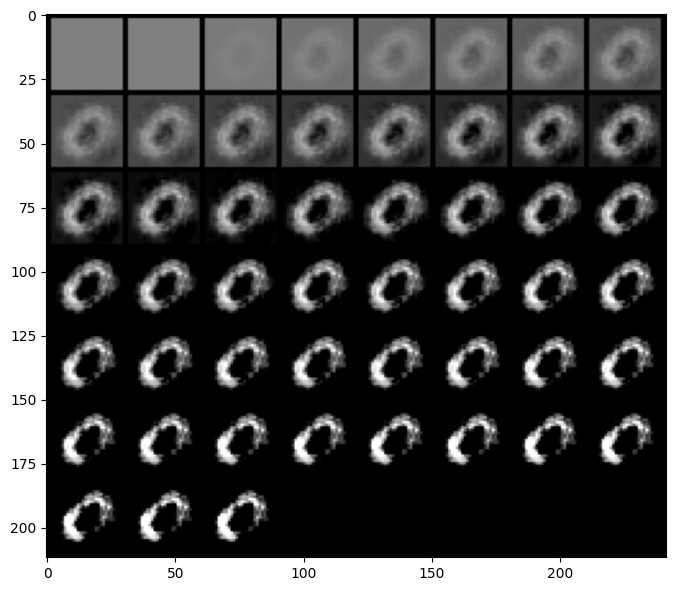

Starting 1


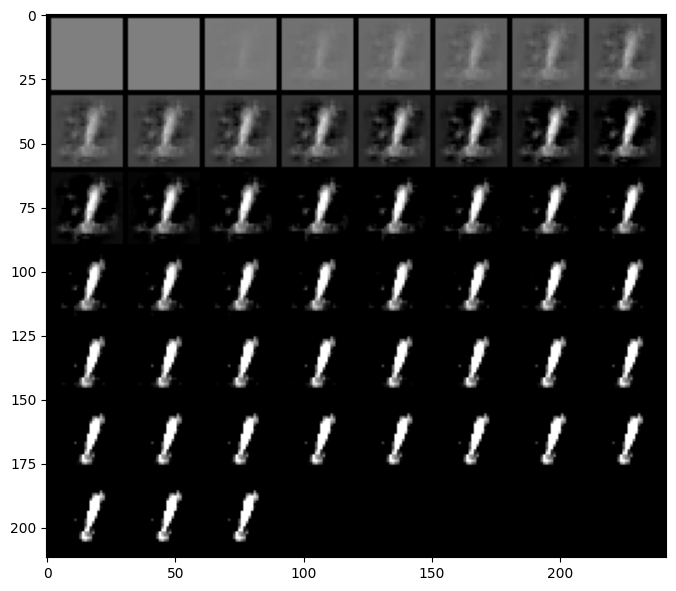

Starting 2


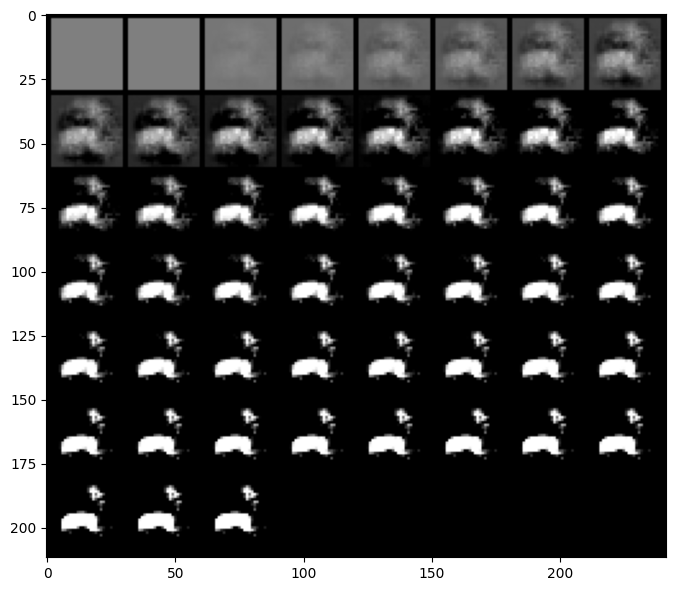

Starting 3


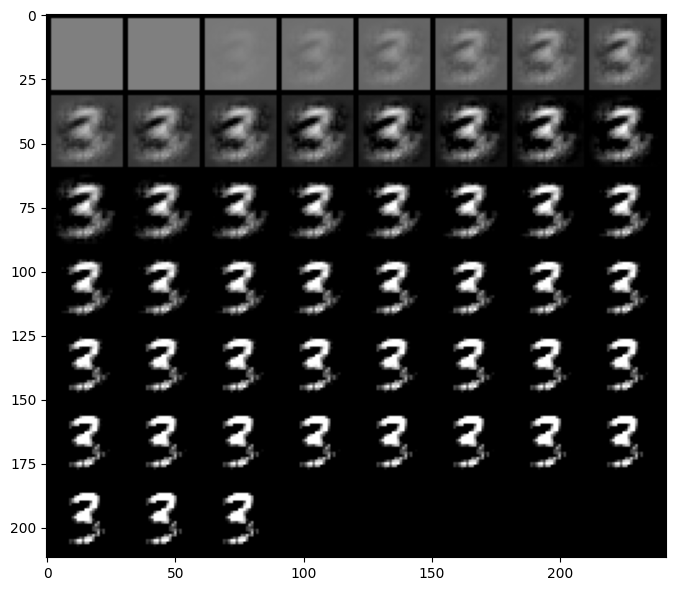

Starting 4


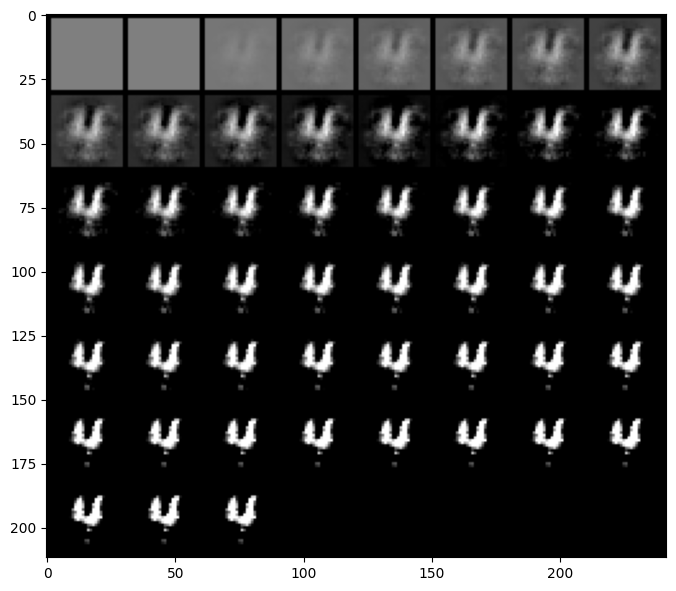

Starting 5


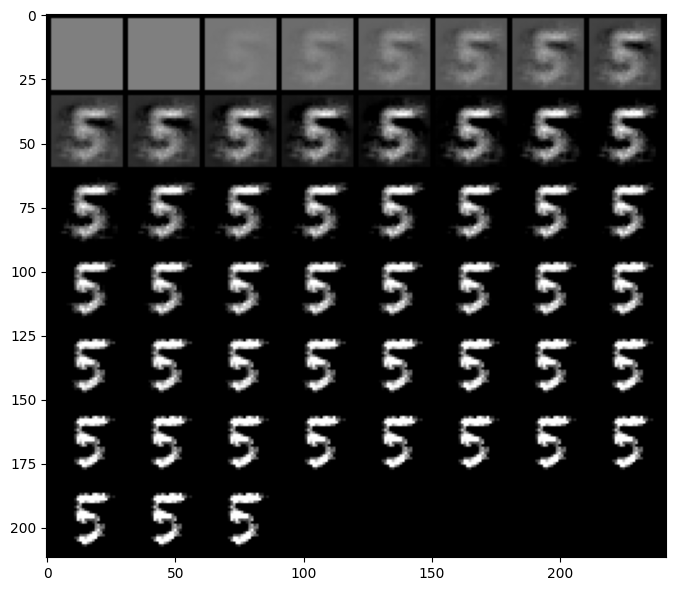

Starting 6


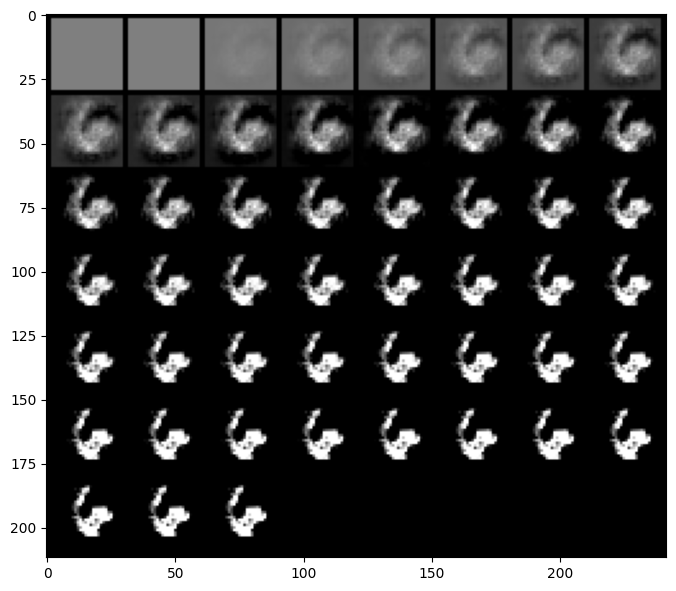

Starting 7


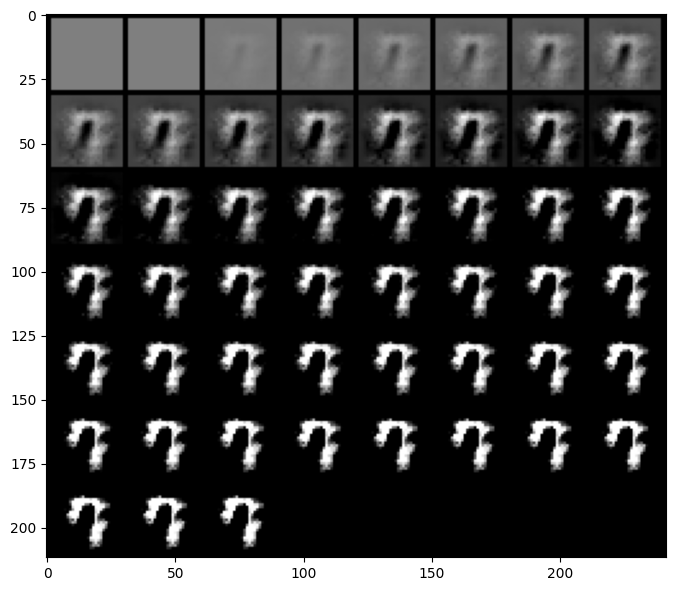

Starting 8


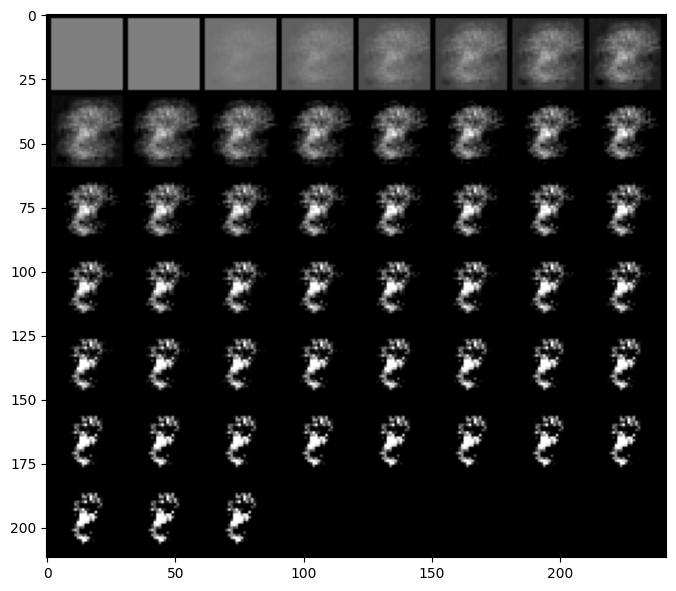

Starting 9


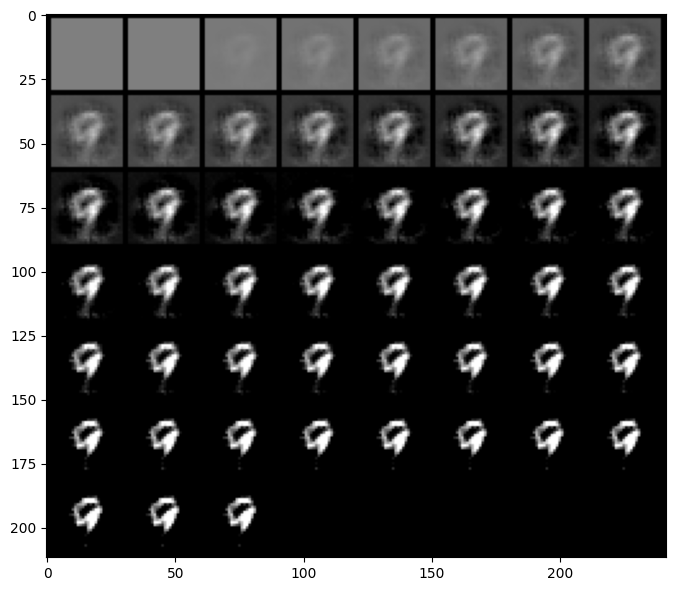

In [ ]:
from torchvision.utils import make_grid
img_start = batch[0][:1]

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
    return data_config.show(torch.tensor(np.array(x)))

# aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

quick_fwd = jax.jit(fwd_energy, static_argnames=("depth"))

# plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))
for i in range(10):
    print(f"Starting {i}")
    energies, allxs = quick_fwd(loaded_model, clamp_label=i, dt=1e-6, depth=50)
    aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])
    plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))
    plt.show()

In [ ]:
linit = jnp.zeros((10,)).at[1].set(1000.).at[0].set(1000.)
loaded_model.layers[-1].g(linit)

DeviceArray([0.48687777, 0.48687777, 0.00328056, 0.00328056, 0.00328056,
             0.00328056, 0.00328056, 0.00328056, 0.00328056, 0.00328056],            dtype=float32)

[<matplotlib.lines.Line2D>]

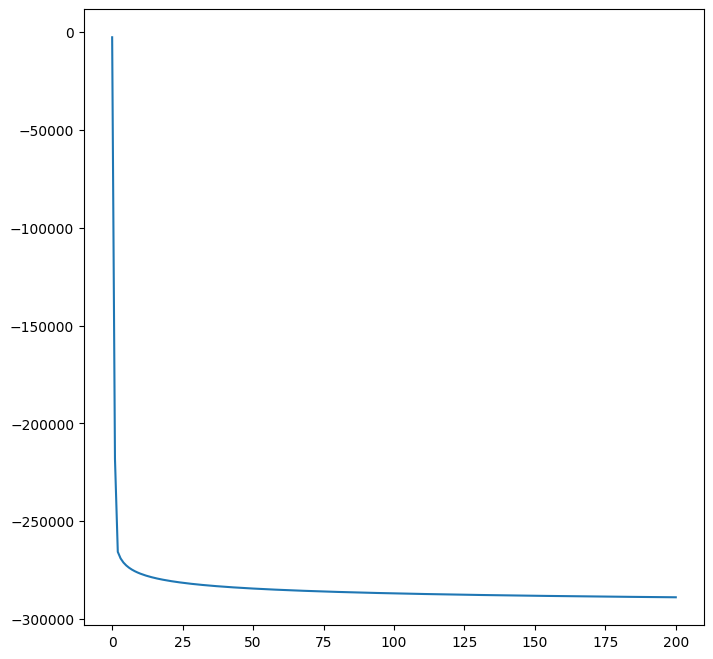

In [ ]:
plt.plot(energies)

<matplotlib.image.AxesImage>

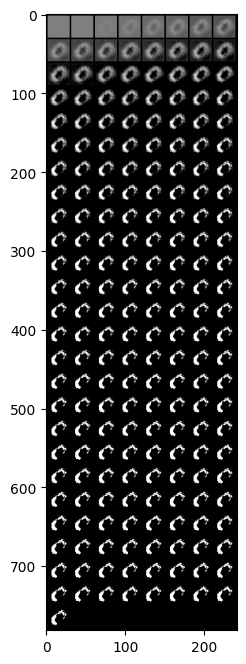

<matplotlib.image.AxesImage>

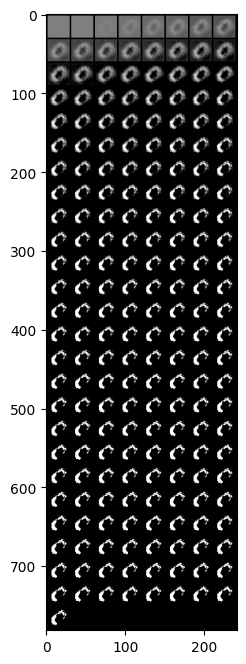

In [ ]:
from torchvision.utils import make_grid

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
    return data_config.show(torch.tensor(np.array(x)))

aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))

# Archive

In [ ]:
# tvision_tfm = tfms.Compose(
#     [
#          tfms.ToTensor(),
#          tfms.RandomAffine(degrees = 10, translate = (0.2, 0.2)),
#     ]
# )
# def transforms(examples):
#     examples["pixels"] = torch.cat([tvision_tfm(image.convert("RGB")) for image in examples["image"]]).detach().cpu().numpy()[None]
#     return examples
# ds_train.set_transform(transforms)


# import datasets
# import torchvision.transforms as tfms
# import torch
# x_train_fname = "data/MNIST/mnist_train.trch"
# x_val_fname = "data/MNIST/mnist_val.trch"

# ds_train = datasets.load_dataset("mnist", split="train")
# ds_val = datasets.load_dataset("mnist", split="test")

# def map_transforms(examples):
#     examples["pixels"] = [tfms.ToTensor()(image) for image in examples["image"]]
#     return examples

# def save_matrix_mnist(ds, fname):
#     ds = ds.map(map_transforms, remove_columns=["image"], batched=True)
#     X = torch.tensor(ds['pixels'])
#     torch.save(X, fname)
#     return X

# def load_mnist():
#     X_train = torch.load(x_train_fname)
#     X_val = torch.load(x_val_fname)
    
#     return X_train.squeeze(1), X_val.squeeze(1)

# X_train = save_matrix_mnist(ds_train, x_train_fname)
# X_val = save_matrix_mnist(ds_val, x_val_fname)

# X_train, X_val = load_mnist()